# Tutorial 03 - Filters
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schedldave/cv2021/blob/main/03_Filters.ipynb)
## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Contents

This notebook covers topics such as Filters, Fourier Transformation and Interpolation

Table of Contents  
- [Filters in OpenCV](#Filters)
    - Average Filter
    - Gaussian Filter
    - Border Handling
- [Fourier Transformation](#Fourier_Spectrum)
    - FFT of Images
    - Inverse FFT
    - Convolution Theorem

# Initilization

As always let's import useful libraries, first.

In [1]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt

We will work with images today. So let's download some with `curl` (the same sources as in `02_OpenCV.ipynb`).

In [2]:
!curl -o "cat.jpg" "https://placekitten.com/256/256"

!curl -o "gogh.jpg" "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Vincent_van_Gogh_-_National_Gallery_of_Art.JPG/367px-Vincent_van_Gogh_-_National_Gallery_of_Art.JPG"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9472    0  9472    0     0  44469      0 --:--:-- --:--:-- --:--:-- 44679
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84904  100 84904    0     0   863k      0 --:--:-- --:--:-- --:--:--  863k


Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [3]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab.patches import cv2_imshow
else:
  print('Not running on CoLab')
  def cv2_imshow(img):
      """A replacement for cv2.imshow() for use in Jupyter notebooks.

        Args:
          img : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
      """
      cv2.imshow('image', img)
      cv2.waitKey(0)
      cv2.destroyAllWindows()

def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

Running on CoLab


# Filters

Image filters in OpenCV are applied with `cv2.filter2D(img,-1,kernel)`, where the image and the kernel are numpy arrays.


## Average

Let's start with a simple average filter

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


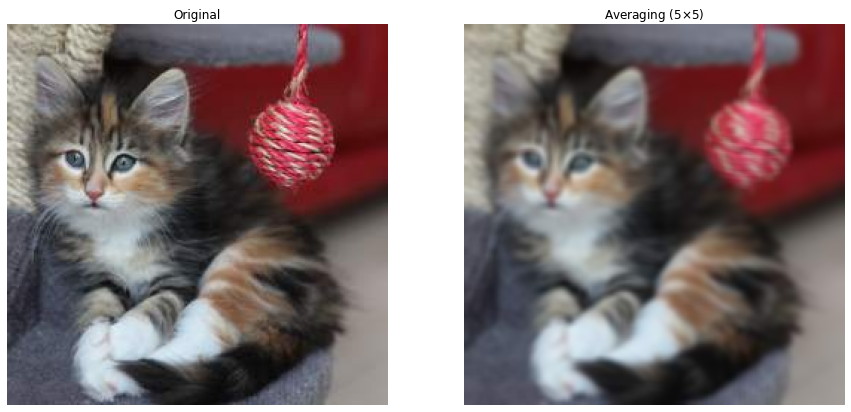

In [4]:
img = cv2.imread('cat.jpg')

k = 5 # kernel size
kernel = np.ones((k,k),np.float32)/(k**2)
print(kernel)
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the filter results clearer
plt.subplot(121),imshow(img),plt.title('Original')
plt.subplot(122),imshow(dst),plt.title(r'Averaging ({}$\times${})'.format(k,k))
plt.show()

## Gaussian Filter

An average filter produces blocky or boxy results, that's why it is also called a box filter. A smoother result can be achieved with a Gaussian Kernel. 
OpenCV's `getGaussianKernel` function produces a one-dimensional seperable Gaussian kernel. To retrieve the 2D variant, we need to (matrix) multiply two 1D kernel.  

[[0.0625 0.25   0.375  0.25   0.0625]]
[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


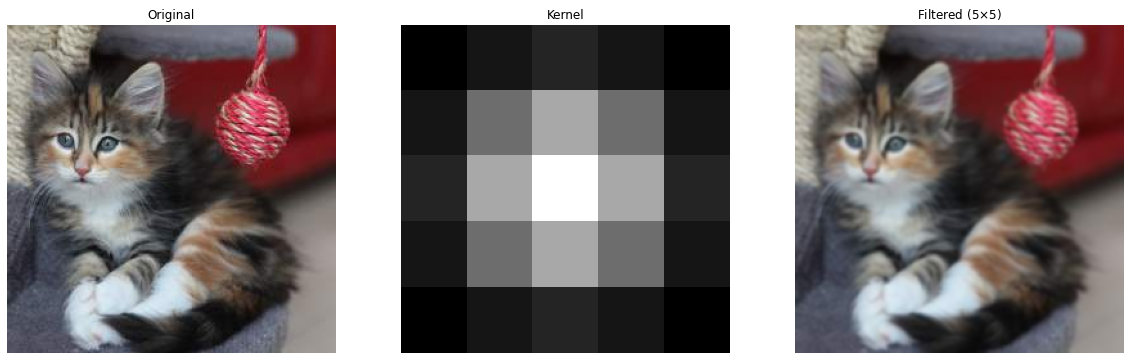

In [6]:
img = cv2.imread('cat.jpg')

k = 5 # kernel size and sigma
kernel = cv2.getGaussianKernel(k,-1)
print(kernel.T)
kernel = kernel @ kernel.T # compute 2D from seperable kernel
print(kernel)
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(20,15)) # make the figure larger
plt.subplot(131),imshow(img),plt.title('Original')
plt.subplot(132),imshow(kernel, cmap = 'gray'),plt.title('Kernel')
plt.subplot(133),imshow(dst),plt.title(r'Filtered ({}$\times${})'.format(k,k))
plt.show()

## Border handling

Border handling especially for large kernels is important. OpenCV provides various options. Default is to reflect the image at the border. 

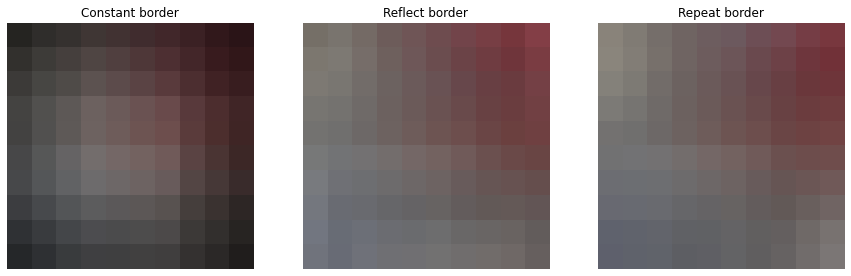

In [ ]:
img = cv2.resize( cv2.imread('cat.jpg'), (10,10) )

k = 7 # kernel size and sigma
kernel = np.ones((k,k),np.float32)/(k**2)
const   = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_CONSTANT)   # 000000|abcdefgh|0000000
reflect = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REFLECT)    # fedcba|abcdefgh|hgfedcb
repeat  = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE)  # aaaaaa|abcdefgh|hhhhhhh


plt.figure(figsize=(15,10)) # make the figure larger
plt.subplot(131),imshow(const),  plt.title(r'Constant border')
plt.subplot(132),imshow(reflect),plt.title(r'Reflect border')
plt.subplot(133),imshow(repeat), plt.title(r'Repeat border')
plt.show()

# Fourier Spectrum

## Fourier Transformation of Images

The numpy library provides a two-dimensional implementation of the Fast Fourier Transformation (FFT): `numpy.fft.fft2`. 
The resulting spectrum is an array with complex numbers, which are supported by numpy. 
We can visualize the spectrum by displaying it like a regular image. Since it is complex we will show only the magnitude (with `numpy.abs`) and we'll use a logarithmic scale. 

dtype('complex128')


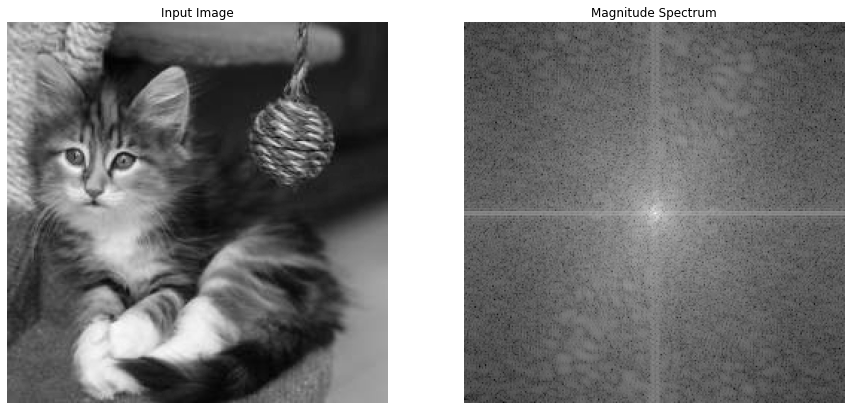

In [11]:
# Load an image and convert it to grayscale
gray = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_RGB2GRAY)

# Transform the image to frequency domain
f = np.fft.fft2(gray)
print(repr(f.dtype))
# Bring the zero-frequency component to the center
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(gray, cmap = 'gray'), plt.title('Input Image')
plt.subplot(122), imshow(magnitude_spectrum, cmap = 'gray'), plt.title('Magnitude Spectrum')
plt.show()

## Inverse Fourier Transformation

While the FFT transform a signal into its spectral domain, the inverse FFT (`numpy.fft.ifft2`) transforms a spectrum into the spatial domain. Note that the resulting array is complex again, where the complex part is zero (or close to zero). 

complex128


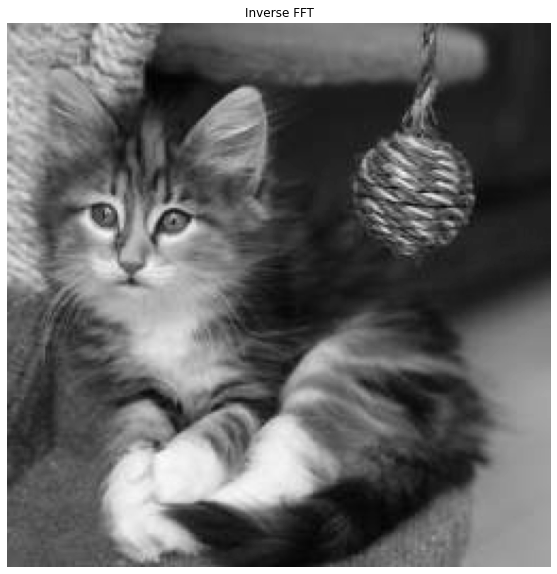

In [14]:
# inverse fourier transform
iff = np.fft.ifft2(f)
print(iff.dtype)
#print(repr(iff))

plt.figure(figsize=(15,10)), imshow(np.abs(iff), cmap='gray'), plt.title('Inverse FFT')
plt.show()

Let's look at some artificial spectra and the corresponding signal. 

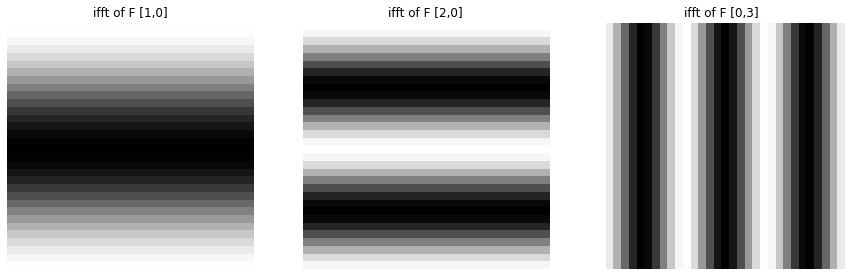

In [15]:
F = np.zeros((32,32),dtype=np.complex128)
F[0,0] = np.prod(F.shape) # DC component (mean)
F10 = F.copy()
F10[1,0] = 1.0
f10 = np.fft.ifft2(F10)

F20 = F.copy()
F20[2,0] = 1.0
f20 = np.fft.ifft2(F20)

F03 = F.copy()
F03[0,3] = 1.0
f03 = np.fft.ifft2(F03)

plt.figure(figsize=(15,10))
plt.subplot(131), imshow(np.abs(f10), cmap='gray'), plt.title('ifft of F [1,0]')
plt.subplot(132), imshow(np.abs(f20), cmap='gray'), plt.title('ifft of F [2,0]')
plt.subplot(133), imshow(np.abs(f03), cmap='gray'), plt.title('ifft of F [0,3]')
plt.show()

## Modifications in the Fourier Spectrum

Let's remove some frequencies by setting them to zero in the spectrum. By converting the spectrum back in the spatial domain (`ifft2`) we can look at the results in the image.

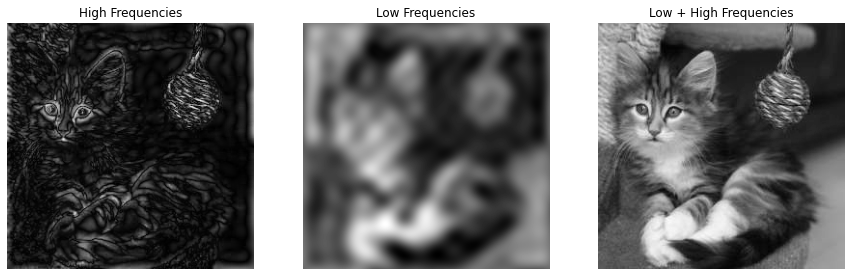

In [ ]:
rows, cols = gray.shape
crow, ccol = round(rows/2) , round(cols/2)

# remove low frequencies with a rectangle size of 20
fcopy = fshift.copy()
fcopy[crow-10:crow+10, ccol-10:ccol+10] = 0
f_ishift = np.fft.ifftshift(fcopy)
img_hf = np.fft.ifft2(f_ishift)
plt.figure(figsize=(15,10))
plt.subplot(131), plt.title( 'High Frequencies')
imshow(np.abs(img_hf), cmap='gray')

# remove high frequencies
fcopy = np.zeros_like(fshift)
fcopy[crow-10:crow+10, ccol-10:ccol+10] = fshift[crow-10:crow+10, ccol-10:ccol+10]
f_ishift = np.fft.ifftshift(fcopy)
img_lf = np.fft.ifft2(f_ishift)
plt.subplot(132), plt.title( 'Low Frequencies')
imshow(np.abs(img_lf), cmap='gray')

# sum the low and high frequencies (Note: it is important to avoid using abs)
plt.subplot(133), plt.title( 'Low + High Frequencies')
imshow(np.abs(img_lf+img_hf), cmap='gray')

## Convolution Theorem

 

A convolution is a point-wise operation in the spectral domain. 
Let's try this with our images. 
For very large kernels OpenCV's filter function uses FFT to speed up computations. 

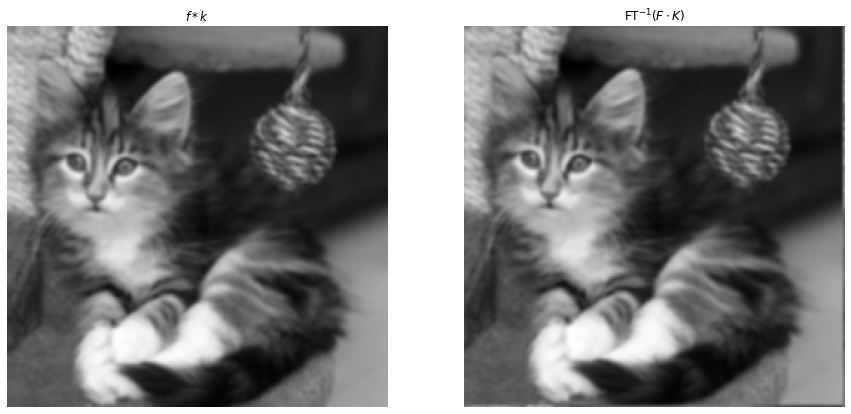

In [ ]:
# Load an image and convert it to grayscale
f = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_RGB2GRAY)
# Transform the image to frequency domain
F = np.fft.fft2(f)

rows, cols = f.shape
crow, ccol = round(rows/2) , round(cols/2)

# create a kernel
k_size = 5 # kernel size and sigma
kh = int(np.floor(k_size/2.0))
kernel = cv2.getGaussianKernel(k_size,-1) 
kernel = kernel @ kernel.T # compute 2D from seperable kernel
k = np.zeros(f.shape)
k[crow-kh-1:crow+kh, ccol-kh-1:ccol+kh] = kernel # extend the size of the kernel
K = np.fft.fft2(k)

# apply the convolution in the spatial domain
d = cv2.filter2D(f,-1,k)

# apply a multiplication in the frequency domain
D = np.zeros_like(F)
D = F * K
D_back = np.fft.ifftshift(np.fft.ifft2(D))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(np.abs(d), cmap='gray'), plt.title('$f * k$')
plt.subplot(122), imshow(np.abs(D_back), cmap='gray'), plt.title(r'FT$^{-1}( F \cdot K )$')
plt.show()

# Exercises (Try it yourself)

## Exercise 1

**Mean Filter:** Implement an average filter yourself. Do not use any OpenCV functions (i.e., `filter2D`).
Hint: you can use loops or slicing.

**(a)** Load the image `gogh.jpg` and apply a $3 \times 3$ filter on the image. Ignore the border (remove 1 pixel at the border).




In [7]:
# Setup Excercise 1

image = cv2.imread("gogh.jpg")
k = 3 # filter size

# use opencv for reference
kernel = np.ones((k,k),np.float32)/(k**2)
ref = cv2.filter2D(image,-1,kernel)
ref = ref[1:-1,1:-1,:] # remove border

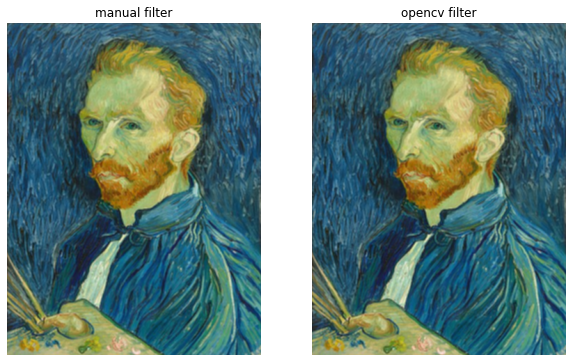

In [9]:
# Solution (a)

avg = np.zeros(image.shape,dtype=np.float32)

# compute average
for xi in range(k):
  for yi in range(k):
    avg[0:avg.shape[0]-xi,0:avg.shape[1]-yi,:] += image[xi:,yi:,:] * kernel[xi,yi]

# remove border
avg = np.round(avg[0:-2,0:-2,:]).astype(np.uint8)

# display
plt.figure(figsize=(10,10))
plt.subplot(121), imshow(avg), plt.title('manual filter')
plt.subplot(122), imshow(ref), plt.title('opencv filter')
plt.show()

# check if close to reference
assert np.isclose(avg,ref).all() == True # if everything is implemented correctly this should not cause an error!


## Exercise 2

**Demosaicing:** Image sensors have a Bayer filter on the sensor elements (pixels). So every 2nd pixel in even rows is red, every 2nd pixel in odd rows is blue, and every 2nd pixel in all rows contains green.
The missing colors need to be [interpolated](https://medium.com/swlh/image-demosaicing-bilinear-interpolation-vs-high-quality-linear-interpolation-5fd2268c4c7a). 

We will do that with linear interpolation.
Implement the interpolation by filtering with a *hat* function.
Think about the shape of the discrete *hat* function and use it.



**(a)** Interpolate the green color channel

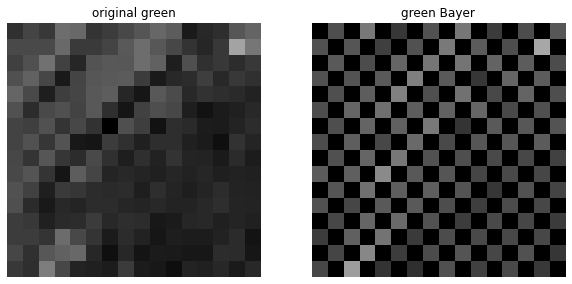

In [ ]:
# Setup Exercise 2
from matplotlib import colors

# from 02_OpenCV.ipynb
image = cv2.imread("gogh.jpg")
green_mask = np.zeros(shape=image.shape[0:2],dtype=np.bool)
green_mask[0::2,1::2] = True
green_mask[1::2,0::2] = True

# construct a Bayer image:
bayer = np.zeros(shape=image.shape[:2],dtype=image.dtype)
# assing colors (BGR)
bayer[:,:][green_mask] = image[:,:,1][green_mask] # Green

# show a zoomed in portion
plt.figure(figsize=(10,10))
plt.subplot(121), imshow(image[:16,:16,2],norm=colors.Normalize(0,255),cmap='gray'), plt.title('original green')
plt.subplot(122), imshow(bayer[:16,:16],norm=colors.Normalize(0,255),cmap='gray'), plt.title('green Bayer')
plt.show()


In [ ]:
# Solution (a)
# green channel

#inter = ...

# display:
#plt.figure(figsize=(15,10))
#plt.subplot(121), imshow(image[:100,:100,1],norm=colors.Normalize(0,255),cmap='gray'), plt.title('original green channel')
#plt.subplot(122), imshow(inter[:100,:100].astype(np.uint8),norm=colors.Normalize(0,255),cmap='gray'), plt.title('interpolated')
#plt.show()


